In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import math
import time
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler


training_data = pd.read_csv("RNN_dataset/Input_Training_Sales.csv")
training_data=training_data[['Year', 'Month', 'Day', 'Store', 'Open', 'Promo', 'Promo2', 'Sales']].values
training_data=pd.DataFrame(training_data)
training_data = training_data.sort_values([3, 0, 1, 2], ascending = [True, True, True, True])
print (training_data)
min_max_scalar = MinMaxScaler()
x_scaled = min_max_scalar.fit_transform(training_data)
training_data = pd.DataFrame(x_scaled)
total_size = len(training_data)
train_size = math.floor(0.7*total_size)
test = training_data.tail(len(training_data)-train_size)
training_data = training_data.head(train_size)


#training_data.drop("Date", inplace = True, axis = 1)'''
training_data = training_data.iloc[:,0:8].values
test = test.iloc[:,0:8].values


print(training_data)
print(test)

           0   1   2     3  4  5  6     7
155509  2013   1   7     1  1  1  0  5614
118507  2013   1   8     1  1  1  0  4994
93609   2013   1  21     1  1  1  0  5394
96871   2013   1  22     1  1  1  0  5720
95767   2013   1  23     1  1  1  0  5578
...      ...  ..  ..   ... .. .. ..   ...
235277  2015   7  31  1115  1  1  1  8680
213621  2015   8   1  1115  1  1  1  6810
270014  2015   8   5  1115  1  1  1  6926
213462  2015   9   1  1115  1  1  1  7498
209363  2015  12   1  1115  1  1  1  8068

[376876 rows x 8 columns]
[[0.         0.         0.2        ... 1.         0.         0.14498218]
 [0.         0.         0.23333333 ... 1.         0.         0.12897061]
 [0.         0.         0.66666667 ... 1.         0.         0.13930066]
 ...
 [0.5        0.81818182 0.76666667 ... 1.         1.         0.1372863 ]
 [0.5        0.90909091 0.33333333 ... 1.         1.         0.16249161]
 [0.5        0.90909091 0.4        ... 1.         1.         0.15182584]]
[[0.5        0.90909091 0

In [2]:
x_training_data = []
y_training_data =[]
for i in range(6, len(training_data)):
    x_training_data.append(training_data[i-6,3:8])
    y_training_data.append(training_data[i,7:8])
    
x_training_data = np.array(x_training_data)
y_training_data = np.array(y_training_data)

print(x_training_data.shape)
print(y_training_data.shape)

(263807, 5)
(263807, 1)


In [3]:
x_training_data = np.reshape(x_training_data,(x_training_data.shape[0], x_training_data.shape[1], 1))
print(x_training_data.shape)
y_training_data=y_training_data.reshape(y_training_data.shape[0], y_training_data.shape[1], 1)
print(y_training_data.shape)

(263807, 5, 1)
(263807, 1, 1)


In [11]:
recurrentNeural = Sequential()
recurrentNeural.add(LSTM(units = 5, return_sequences = True, input_shape = (x_training_data.shape[1], 1), activation = 'tanh'))
recurrentNeural.add(Dropout(0.2))
recurrentNeural.add(LSTM(units = 5, return_sequences = True, activation = 'tanh'))
recurrentNeural.add(Dropout(0.2))
recurrentNeural.add(LSTM(units = 5, activation = None))
recurrentNeural.add(Dropout(0.2))
recurrentNeural.add(Dense(units = 1))
recurrentNeural.compile(optimizer = 'sgd', loss = 'mean_squared_error')
history = recurrentNeural.fit(x_training_data, y_training_data, shuffle = False, epochs = 4, batch_size = 1)

Epoch 1/4
263807/263807 [==============================] - 876s 3ms/step - loss: 0.0022
Epoch 2/4
263807/263807 [==============================] - 858s 3ms/step - loss: 0.0023
Epoch 3/4
263807/263807 [==============================] - 854s 3ms/step - loss: 0.0023
Epoch 4/4
263807/263807 [==============================] - 855s 3ms/step - loss: 0.0023


KeyError: 'val_loss'

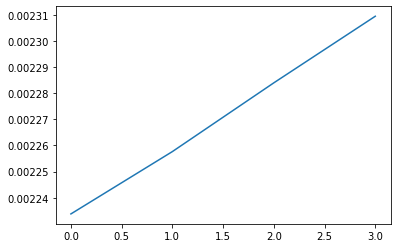

In [12]:
plt.plot(history.history['loss'], label = 'Training Error')
plt.plot(history.history['val_loss'], label = 'Validation Error')
plt.legend()

In [13]:
x_testing_data = []
y_testing_data =[]
x_temp_testing_data = []
for i in range(7, len(test)):
    x_testing_data.append(test[i-7,3:8])
    y_testing_data.append(test[i, 7:8])
    x_temp_testing_data.append(test[i, 0:7])
    
    
x_testing_data = np.array(x_testing_data)
y_testing_data = np.array(y_testing_data)
x_temp_testing_data = np.array(x_temp_testing_data)

print(x_testing_data.shape)
print(y_testing_data.shape)
final_x_test_data = np.array(x_testing_data)
final_x_test_data = np.reshape(final_x_test_data, (final_x_test_data.shape[0], final_x_test_data.shape[1], 1))
final_y_test_data = np.array(y_testing_data)
final_y_test_data = np.reshape(final_y_test_data, (final_y_test_data.shape[0], final_y_test_data.shape[1], 1))
print(final_x_test_data.shape)

(113056, 5)
(113056, 1)
(113056, 5, 1)


In [14]:
predicted_Sales = recurrentNeural.predict(final_x_test_data)
outputVal = np.concatenate((x_temp_testing_data, predicted_Sales), axis = 1)
print(outputVal)
predicted_Sales = min_max_scalar.inverse_transform(outputVal)
print('#### Predicted Sales ####')
predicted_Sales=pd.DataFrame(predicted_Sales)
print(predicted_Sales)

orig=np.concatenate((x_temp_testing_data, y_testing_data), axis = 1)
orig=min_max_scalar.inverse_transform(orig)
print('\n#### Original Sales ####')
orig=pd.DataFrame(orig)
print(orig)

[[0.5        1.         0.46666667 ... 1.         1.         0.16130094]
 [0.5        1.         0.5        ... 1.         1.         0.16130543]
 [0.5        1.         0.53333333 ... 1.         1.         0.16130012]
 ...
 [1.         0.63636364 0.13333333 ... 1.         1.         0.16184697]
 [1.         0.72727273 0.         ... 1.         1.         0.16185462]
 [1.         1.         0.         ... 1.         1.         0.16184764]]
#### Predicted Sales ####
             0     1     2       3    4    5    6            7
0       2014.0  12.0  15.0   782.0  1.0  1.0  1.0  6245.895088
1       2014.0  12.0  16.0   782.0  1.0  1.0  1.0  6246.068766
2       2014.0  12.0  17.0   782.0  1.0  1.0  1.0  6245.863353
3       2014.0  12.0  18.0   782.0  1.0  1.0  1.0  6245.833349
4       2014.0  12.0  19.0   782.0  1.0  1.0  1.0  6246.028375
...        ...   ...   ...     ...  ...  ...  ...          ...
113051  2015.0   7.0  31.0  1115.0  1.0  1.0  1.0  6266.799321
113052  2015.0   8.0   1.0

In [15]:
to_predict_data = pd.read_csv("RNN_dataset/Testing_Sales.csv")
to_predict_data=to_predict_data[['Year', 'Month', 'Day', 'Store', 'Open', 'Promo', 'Promo2', 'Sales']].values
to_predict_data=pd.DataFrame(to_predict_data)
min_max_scalar2 = MinMaxScaler()
to_predict_data = min_max_scalar2.fit_transform(to_predict_data)
to_predict_data = pd.DataFrame(to_predict_data)
to_predict_data = to_predict_data.iloc[:,0:8].values

x_predict_data = []
y_predict_data =[]
x_temp_predict_data = []
for i in range(0, len(to_predict_data)):
    x_predict_data.append(test[i,3:7])
    y_predict_data.append(test[i, 7:8])
    x_temp_predict_data.append(test[i, 0:7])
    
    
    
x_predict_data = np.array(x_predict_data)
y_predict_data = np.array(y_predict_data)


final_x_predict_data = np.array(x_predict_data)
final_x_predict_data = np.reshape(final_x_predict_data, (final_x_predict_data.shape[0], final_x_predict_data.shape[1], 1))
final_y_predict_data = np.array(y_predict_data)
final_y_predict_data = np.reshape(final_y_predict_data, (final_y_predict_data.shape[0], final_y_predict_data.shape[1], 1))



predicted_Sales = recurrentNeural.predict(final_x_predict_data)
outputVal = np.concatenate((x_temp_predict_data, predicted_Sales), axis = 1)
print(outputVal)
predicted_Sales = min_max_scalar.inverse_transform(outputVal)
print('#### Predicted Sales ####')
predicted_Sales=pd.DataFrame(predicted_Sales)
print(predicted_Sales)

[[0.5        0.90909091 0.43333333 ... 1.         1.         0.16127549]
 [0.5        0.90909091 0.76666667 ... 1.         1.         0.16127549]
 [0.5        0.90909091 0.8        ... 1.         1.         0.16127549]
 ...
 [1.         0.36363636 0.66666667 ... 1.         0.         0.1613096 ]
 [1.         0.36363636 0.7        ... 1.         0.         0.1613096 ]
 [1.         0.45454545 0.03333333 ... 1.         0.         0.1613096 ]]
#### Predicted Sales ####
            0     1     2      3    4    5    6            7
0      2014.0  11.0  14.0  782.0  1.0  1.0  1.0  6244.909567
1      2014.0  11.0  24.0  782.0  1.0  1.0  1.0  6244.909567
2      2014.0  11.0  25.0  782.0  1.0  1.0  1.0  6244.909567
3      2014.0  11.0  26.0  782.0  1.0  1.0  1.0  6244.909567
4      2014.0  11.0  27.0  782.0  1.0  1.0  1.0  6244.909567
...       ...   ...   ...    ...  ...  ...  ...          ...
41083  2015.0   5.0  19.0  903.0  1.0  1.0  0.0  6246.230326
41084  2015.0   5.0  20.0  903.0  1.0  1.0

In [16]:
predicted_Sales.to_csv("RNN_dataset/outputSales.csv")